In [1]:
from firedrake import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Advection-Diffusion-Reaction Equations
$$\frac{\partial u_1}{\partial t} + w \cdot \nabla u_1 - \nabla \cdot (\epsilon \nabla u_1) = f_1 - K u_1 u_2$$
$$\frac{\partial u_2}{\partial t} + w \cdot \nabla u_2 - \nabla \cdot (\epsilon \nabla u_2) = f_2 - K u_1 u_2$$
$$\frac{\partial u_3}{\partial t} + w \cdot \nabla u_3 - \nabla \cdot (\epsilon \nabla u_3) = f_3 + K u_1 u_2 - Ku_3$$

This applies for three species A, B, C where $A + B \rightarrow C$. In our case, $u_1 = A$, $u_2 = B$, $u_3 = C$.

In the equations above, the reaction takes place across the whole domain, reactants are diffused by $\epsilon$, and reactants are advected by $w$.

# Variational Formulation

![Variational Form](adv-diff-react-variational-form.png)

In [2]:
# Mesh parameters
Lx = 5
Ly = 1
x_elems = 100
y_elems = 20
mesh = RectangleMesh(x_elems, y_elems, Lx, Ly)
x, y = SpatialCoordinate(mesh)

In [3]:
# Simulation time parameters
T = 5.
num_steps = 500
dt = T / num_steps
k = Constant(dt)

# Model parameters
eps = Constant(1.5)  # Diffusion Rate
K = Constant(100.0)    # Reaction Rate

In [10]:
# Advection definition
a = 3
b = 4
c = 5
d = 2
w_uv = as_vector((
    10 * sin(x**2),
    cos(y**2)
))
W = VectorFunctionSpace(mesh, family='CG', degree=2, dim=2)
w = interpolate(w_uv, W)

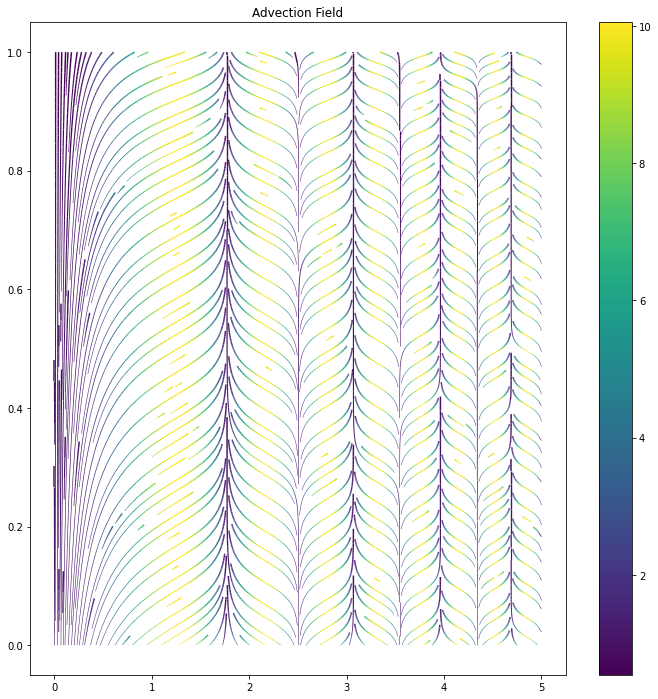

In [11]:
# Plot the wind field
fig, axes = plt.subplots(figsize=(12, 12))
axes.set_title('Advection Field')
opts = {'resolution': 1/64, 'seed': 1}
streamlines = streamplot(w, axes=axes, **opts)
fig.colorbar(streamlines);

In [6]:
# Define the mixed elements
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])

# Define the test functions
V = FunctionSpace(mesh, element)
v_1, v_2, v_3 = TestFunctions(V)

# No trial functions since the problem is nonlinear
u = Function(V)
u_n = Function(V)
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

# Define source terms
circle_r = 0.1
f_1 = conditional(pow(x-0.5, 2) + pow(y - 0.5, 2) < circle_r**2, 1.0, 0)
f_2 = conditional(pow(x-2.5, 2) + pow(y - 0.5, 2) < circle_r**2, 1.0, 0)
f_3 = Constant(0)

# Build the variational form
F_u1 = ((u_1 - u_n1) / k)*v_1*dx + dot(w, grad(u_1))*v_1*dx + eps*dot(grad(u_1), grad(v_1))*dx + K*u_1*u_2*v_1*dx
F_u2 = ((u_2 - u_n2) / k)*v_2*dx + dot(w, grad(u_2))*v_2*dx + eps*dot(grad(u_2), grad(v_2))*dx + K*u_1*u_2*v_2*dx
F_u3 = ((u_3 - u_n3) / k)*v_3*dx + dot(w, grad(u_3))*v_3*dx + eps*dot(grad(u_3), grad(v_3))*dx - K*u_1*u_2*v_3*dx + K*u_3*v_3*dx
L = f_1*v_1*dx + f_2*v_2*dx + f_3*v_3*dx

F = F_u1 + F_u2 + F_u3 - L

In [7]:

# Create VTK files for visualization output
vtkfile_u_1 = File('reaction_system/u_1.pvd')
vtkfile_u_2 = File('reaction_system/u_2.pvd')
vtkfile_u_3 = File('reaction_system/u_3.pvd')

# Solve the system
t=0
for n in tqdm(range(num_steps)):
    t += dt

    w_uv = as_vector((
        10,
        sin(t**2)
    ))
    w = interpolate(w_uv, W)

    solve(F == 0, u)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()
    vtkfile_u_1.write(_u_1, time=t)
    vtkfile_u_2.write(_u_2, time=t)
    vtkfile_u_3.write(_u_3, time=t)

    # Update previous solution
    u_n.assign(u)

100%|██████████| 500/500 [05:44<00:00,  1.45it/s]
